Import libraries

In [1]:
import pandas as pd
import re
import numpy as np

Open [food availability data from Statistics Canada](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3210005401). The CSV file was converted to an Excel file before loaded here.

In [2]:
df = pd.read_excel('food_availability.xlsx', sheet_name=0)

# Remove unwanted categories
df = df[~df['Commodity'].str.contains(', total population')]
df = df[~df['Commodity'].str.contains(', milk solids')]
df = df[~df['Commodity'].str.contains(', carcass weight')]
df = df[~df['Commodity'].str.contains(', fat content')]
df = df[~df['Commodity'].str.contains(', sugar content')]

# Create a column for fresh, frozen, canned, dried
df['Packaging'] = df.Commodity.str.extract('(canned|frozen|fresh|juice|dried)')

# Create column with food group
def food_groups(row):
    dairy = re.compile('(milk|cheese|yogurt|cream|butter)', re.IGNORECASE)
    drinks = re.compile('(coffee|tea|wines|drinks|beer|spirits|juice)', re.IGNORECASE)
    meat = re.compile('(beef|veal|chicken|hen|pork|turkey|mutton|offal|fish)', re.IGNORECASE)
    grains = re.compile('(flour|oats|barley|corn|rice|potatoes)', re.IGNORECASE)
    fruits = re.compile('(Apple|Apricots|Banana|Blueberries|Cherries|Coconut|Cranberries|Dates|Figs|Grapes|Melons|Nectarines|Peaches|Pears|Pineapple|Plums|Raspberries|Strawberries|Fruits|Orange|Lemon|Grapefruit|Grape|Watermelons|Wintermelons|Limes|Olives|Guavas|Papayas|Quinces|Mandarins)', re.IGNORECASE)
    vegetables = re.compile('(Beans|Beets|sprouts|Cabbage|Carrots|Cauliflower|Celery|Corn|Cucumbers|Lettuce|Mushrooms|Onions|Parsnips|Peas|Peppers|Radishes|Rutabagas|Spinach|Tomato|Vegetables|Asparagus|Broccoli|Artichokes|Avocados|Rappini|Eggplants|Garlic|Kohlrabi|Leeks|Manioc|Okra|Parsley|Pumpkins)', re.IGNORECASE)
    
    if re.search(dairy, row['Commodity']):
        return 'dairy'
    elif re.search(meat, row['Commodity']):
        return 'meat'
    elif re.search(grains, row['Commodity']):
        return 'grains'
    elif re.search(drinks, row['Commodity']):
        return 'drinks'
    elif re.search(fruits, row['Commodity']):
        return 'fruits'
    elif re.search(vegetables, row['Commodity']):
        return 'vegetables'
    else:
        return 'other'
    
df['food_group'] = df.apply(food_groups, axis = 1)
df['food_group'].value_counts()

vegetables    8646
fruits        8022
dairy         2886
drinks        2379
other         2012
meat          1972
grains        1958
Name: food_group, dtype: int64

Filter out total food available before waste and spoilage

In [3]:
raw = df[df['Food categories'] == 'Food available']
raw.head()

,REF_DATE,GEO,DGUID,Food categories,Commodity,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS,Packaging,food_group
0,1960,Canada,2016A000011124,Food available,Wheat flour,"Kilograms per person, per year",194,units,0,v108209,1.1.1,59.19,NaN,NaN,NaN,2,NaN,grains
1,1960,Canada,2016A000011124,Food available,Rye flour,"Kilograms per person, per year",194,units,0,v108220,1.1.2,0.46,NaN,NaN,NaN,2,NaN,grains
2,1960,Canada,2016A000011124,Food available,Oatmeal and rolled oats,"Kilograms per person, per year",194,units,0,v108231,1.1.3,2.15,NaN,NaN,NaN,2,NaN,grains
3,1960,Canada,2016A000011124,Food available,Pot and pearl barley,"Kilograms per person, per year",194,units,0,v108242,1.1.4,0.09,NaN,NaN,NaN,2,NaN,grains
4,1960,Canada,2016A000011124,Food available,Corn flour and meal,"Kilograms per person, per year",194,units,0,v108253,1.1.5,0.75,NaN,NaN,NaN,2,NaN,grains


These are various data preparation steps. For example, I wanted to only add the fresh equivalent weight of produce, whether they come in cans, frozen, or dried.

In [4]:
# Calculate only fresh equivalent for foods
raw['Fresh'] = np.where(raw.Commodity.str.contains('fresh equivalent'),
    'fresh equivalent',
    None)

# Create column with broadest food category
raw['Broad_cat'] = np.where(raw.Commodity.str.contains('(canned|frozen|fresh|dried)'),
    raw.Commodity.str.extract('(.*?),? (canned|frozen|fresh|dried|dry),?')[0],
    raw.Commodity)

# Remove remaining descriptors after comma
raw['Broad_cat'] = raw['Broad_cat'].str.replace(', .*', '')

# Fix canned beans and fish
raw['Broad_cat'] = raw['Broad_cat'].replace('Baked and', 'Baked beans')
raw['Broad_cat'] = raw['Broad_cat'].replace('Fresh and', 'Fresh and frozen sea fish')

# Consolidate seafood into one category
raw['Broad_cat'] = np.where(raw['Broad_cat'].str.contains('fish'), 'Fish and seafood', raw.Broad_cat)

# Drop juice measured in kg
juice_kg = raw[(raw.Commodity.str.contains('juice')) & (raw.UOM.str.contains('Kilograms'))].index
raw = raw.drop(juice_kg)

# Keep only boneless value for meat
non_boneless = raw[(raw.Commodity.str.contains('eviscerated weight')) | (raw.Commodity.str.contains('carcass weight')) & (raw.food_group == 'meat')].index
raw = raw.drop(non_boneless)

# Keep only total potatoes, fresh and processed
drop_potatoes = raw[(raw.Commodity.str.contains('Potatoes')) & (~raw.Commodity.str.contains('white fresh and processed, fresh equivalent'))].index
raw = raw.drop(drop_potatoes)

raw.Broad_cat.unique()

C:\Users\rochar\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\rochar\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys
C:\Users\rochar\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Us

array(['Wheat flour', 'Rye flour', 'Oatmeal and rolled oats',
       'Pot and pearl barley', 'Corn flour and meal', 'Rice',
       'Breakfast food', 'Sugar refined', 'Maple sugar', 'Honey',
       'Dry beans', 'Baked beans', 'Dry peas', 'Peanuts', 'Tree nuts',
       'Tea', 'Coffee', 'Cocoa', 'Ale', 'Distilled spirits', 'Wines',
       'Cheddar cheese', 'Processed cheese', 'Variety cheese',
       'Cottage cheese', 'Powder skim milk', 'Powder buttermilk',
       'Powder whey', 'Concentrated whole milk',
       'Sweetened concentrated whole milk', 'Concentrated skim milk',
       'Sweetened concentrated skim milk', 'Ice cream',
       'Standard milk 3.25%', 'Buttermilk', 'Partly skimmed milk 2%',
       'Skim milk', 'Chocolate and other flavoured milk', 'Yogurt',
       'Turkey', 'Eggs', 'Pork', 'Beef', 'Veal', 'Beef and veal total',
       'Mutton and lamb', 'Offal', 'Butter', 'Margarine', 'Salad oils',
       'Shortening and shortening oils', 'Apples', 'Apple juice',
       'Apple pie

Export final data table for making charts

In [5]:
fresh = raw[raw.Fresh.notnull()]
notfresh = raw[(raw.Fresh.isnull()) & (~raw.Commodity.str.contains('(canned|frozen|fresh|dried)$'))]
pd.concat([fresh, notfresh]).to_csv('food_available_filtered.csv', index=False)

C:\Users\rochar\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


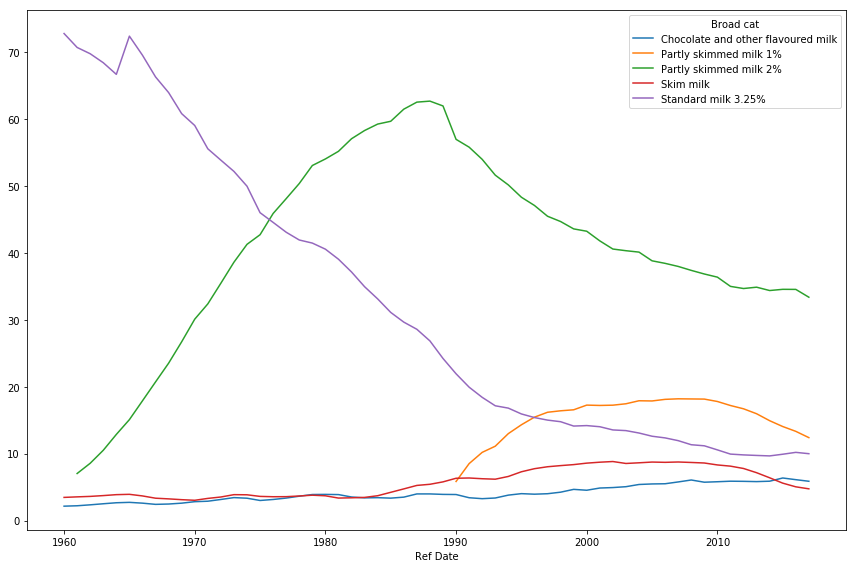

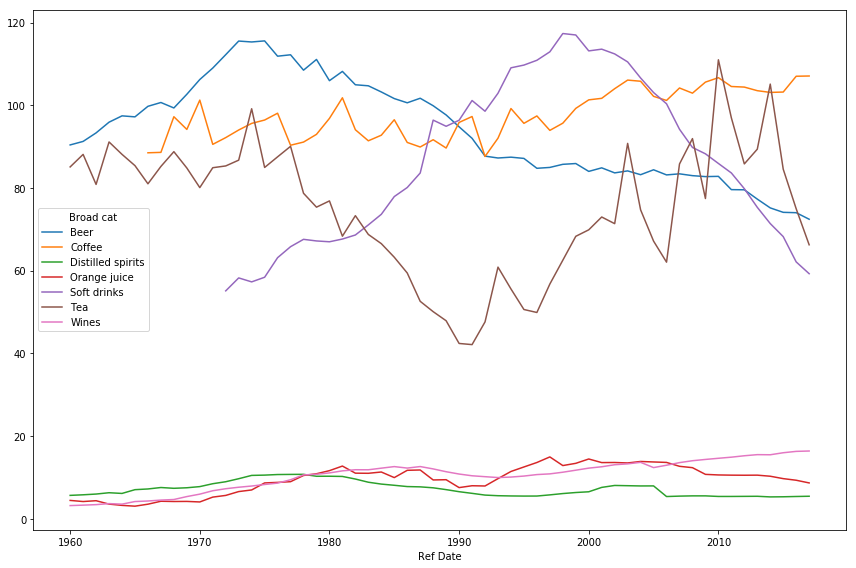

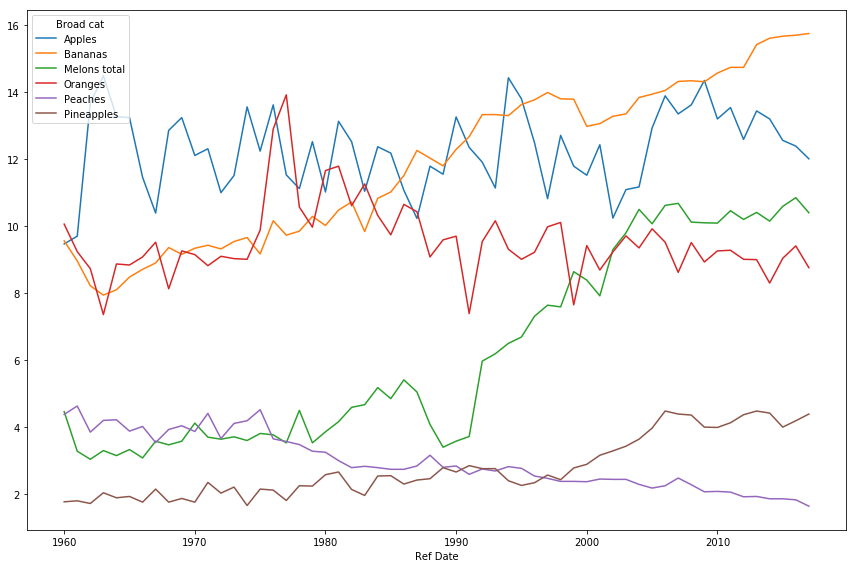

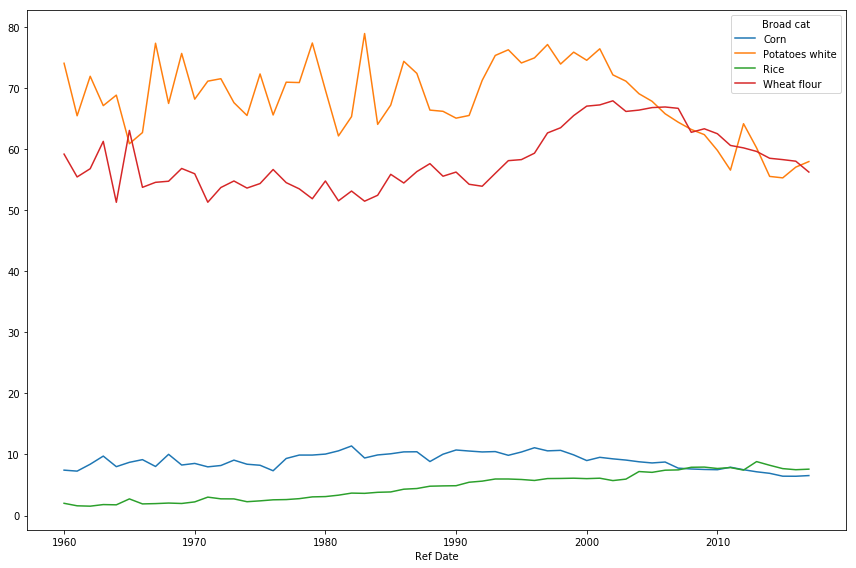

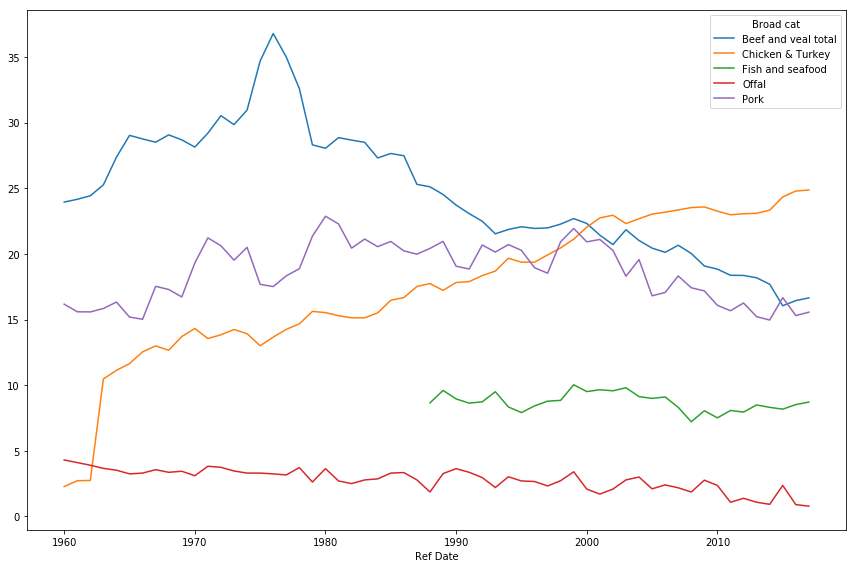

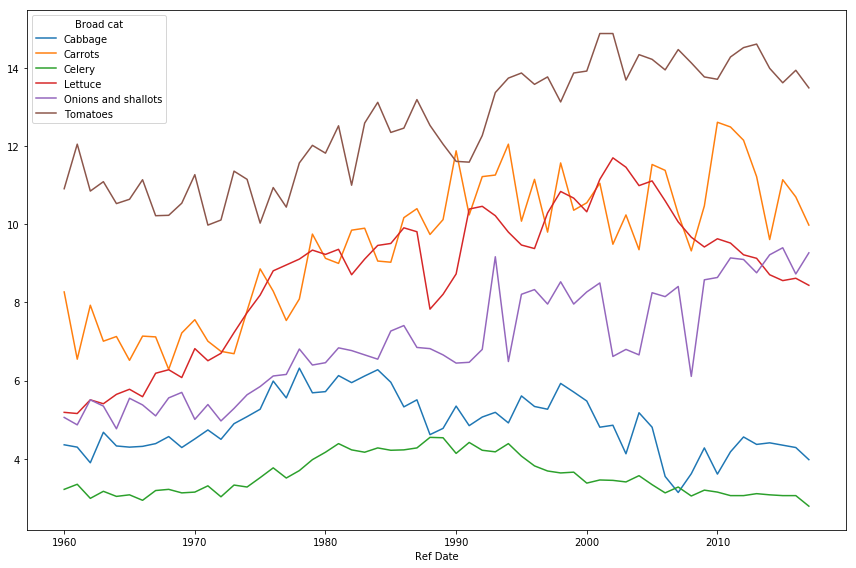

In [324]:
for cat in final.food_group.unique():
    (final[final.food_group == cat]
     .pivot_table(index='Ref Date', columns='Broad cat', values='Value')
     .plot(figsize=(12,8))
    )
    plt.tight_layout()
    plt.savefig(cat + '.png')

In [325]:
cats = final.food_group.unique()
final[final.food_group == cats[4]].pivot_table(index='Ref Date', columns='Broad cat', values='Value').to_clipboard(sep=',')

### Food waste
This section examines the food availability adjusted for loss to see how much of each fod type is wasted

In [86]:
adj = df[df['Food categories'] == 'Food available adjusted for losses']
adj = adj[~adj['Commodity'].str.contains(', total population')]

adj['Broad_cat'] = np.where(adj.Commodity.str.contains('(canned|frozen|fresh|juice|dried)'),
    adj.Commodity.str.extract('(.*?),? (canned|frozen|fresh|dried),?')[0],
    adj.Commodity)

adj.head()

C:\Users\rochar\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


,REF_DATE,GEO,DGUID,Food categories,Commodity,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS,Packaging,Broad_cat
267,1960,Canada,2016A000011124,Food available adjusted for losses,Wheat flour,"Kilograms per person, per year",194,units,0,v41356444,1.2.1,41.67,NaN,NaN,NaN,2,NaN,Wheat flour
268,1960,Canada,2016A000011124,Food available adjusted for losses,Rye flour,"Kilograms per person, per year",194,units,0,v41356445,1.2.2,0.32,NaN,NaN,NaN,2,NaN,Rye flour
269,1960,Canada,2016A000011124,Food available adjusted for losses,Oatmeal and rolled oats,"Kilograms per person, per year",194,units,0,v41356446,1.2.3,1.21,NaN,NaN,NaN,2,NaN,Oatmeal and rolled oats
270,1960,Canada,2016A000011124,Food available adjusted for losses,Pot and pearl barley,"Kilograms per person, per year",194,units,0,v41356447,1.2.4,0.05,NaN,NaN,NaN,2,NaN,Pot and pearl barley
271,1960,Canada,2016A000011124,Food available adjusted for losses,Corn flour and meal,"Kilograms per person, per year",194,units,0,v41356448,1.2.5,0.52,NaN,NaN,NaN,2,NaN,Corn flour and meal


In [87]:
adj['Broad_cat'] = adj['Broad_cat'].str.replace(', .*', '')

# Fix canned beans and fish
adj['Broad_cat'] = adj['Broad_cat'].replace('Baked and', 'Baked beans')
adj['Broad_cat'] = adj['Broad_cat'].replace('Fresh and', 'Fresh and frozen sea fish')

adj.Broad_cat

267                            Wheat flour
268                              Rye flour
269                Oatmeal and rolled oats
270                   Pot and pearl barley
271                    Corn flour and meal
272                                   Rice
273                         Breakfast food
274                          Sugar refined
275                            Maple sugar
276                                  Honey
277                              Dry beans
278                            Baked beans
279                               Dry peas
280                                Peanuts
281                              Tree nuts
282                                    Tea
283                                  Cocoa
285                                    Ale
287                      Distilled spirits
289                                  Wines
290                         Cheddar cheese
291                       Processed cheese
292                         Variety cheese
293        

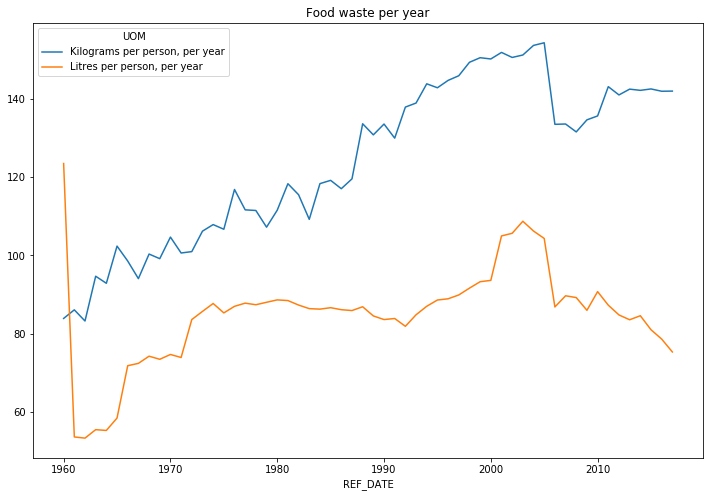

In [176]:
# Calculate waste by subtracting total availability from availability adjusted for loss

%matplotlib inline

pd.DataFrame(
    raw[raw.Commodity.isin(adj.Commodity.unique())].groupby(['REF_DATE', 'UOM']).sum().VALUE 
    - adj.groupby(['REF_DATE', 'UOM']).sum().VALUE).reset_index().pivot_table(index='REF_DATE', columns='UOM', values='VALUE').plot(figsize=(12,8), title="Food waste per year")